In [18]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import numpy as np

# 导入util模块的各种方法
# from keras.utils.np_utils import to_categorical
# 导入数据集
# from keras.datasets import imdb
# from keras.datasets import mnist
# 导入模型、优化器、损失函数等等
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers
# 导入Keras图像处理模块
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
# 导入预训练模型
from keras.applications import VGG16
# 导入系统库
import os

# 05. 深度学习用于计算机视觉
卷积神经网络，也叫`convnet`，是计算机视觉应用几乎都在使用的一种深度学习模型。你将学到将卷积神经网络应用于图像分类问题，特别是那些训练数据集较小的问题。如果你工作的地方并非大型科技公司，这也将是你最常见的使用场景。

## 5.3 卷积神经网络简介
想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用`预训练网络`。`预训练网络`（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。

举个例子，你在`ImageNet`上训练了一个网络（其类别主要是动物和日常用品），然后将这个训练好的网络应用于某个不相干的任务，比如在图像中识别家具。这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比的重要优势，它使得深度学习对小数据问题非常有效。

本例中，假设有一个在`ImageNet`数据集（140 万张标记图像，1000 个不同的类别）上训练好的大型卷积神经网络。`ImageNet`中包含许多动物类别，其中包括不同种类的猫和狗，因此可以认为它在猫狗分类问题上也能有良好的表现。

我们将使用`VGG16`架构，它由`Karen Simonyan`和`Andrew Zisserman`在2014年开发。对于`ImageNet`，它是一种简单而又广泛使用的卷积神经网络架构。虽然`VGG16`是一个比较旧的模型，性能远比不了当前最先进的模型，而且还比许多新模型更为复杂，但我之所以选择它，是因为它的架构与你已经熟悉的架构很相似，因此无须引入新概念就可以很好地理解。

> 参见`Karen Simonyan`和`Andrew Zisserman`于2014年发表的文章“Very deep convolutional networks for large-scale image recognition”

使用预训练网络有两种方法：`特征提取`（feature extraction）和`微调模型`（fine-tuning）。

### 5.3.1 特征提取
`特征提取`是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

如前所述，用于图像分类的卷积神经网络包含两部分：首先是一系列池化层和卷积层，最后是一个密集连接分类器。第一部分叫作模型的`卷积基`（convolutional base）。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器（见`图5-14`）。

<img src="images/05_14.png" style="width:500px;"/>

**为什么仅重复使用卷积基？我们能否也重复使用密集连接分类器?**

一般来说，应该避免这么做。原因在于卷积基学到的表示可能更加通用，因此更适合重复使用。卷积神经网络的特征图表示通用概念在图像中是否存在，无论面对什么样的计算机视觉问题，这种特征图都可能很有用。但是，分类器学到的表示必然是针对于模型训练的类别，其中仅包含某个类别出现在整张图像中的概率信息。此外，密集连接层的表示不再包含物体在输入图像中的位置信息。密集连接层舍弃了空间的概念，而物体位置信息仍然由卷积特征图所描述。如果物体位置对于问题很重要，那么密集连接层的特征在很大程度上是无用的。

**注意**，某个卷积层提取的表示的通用性（以及可复用性）取决于该层在模型中的深度。模型中更靠近底部的层提取的是局部的、高度通用的特征图（比如视觉边缘、颜色和纹理），而更靠近顶部的层提取的是更加抽象的概念（比如“猫耳朵”或“狗眼睛”）。因此，如果你的新数据集与原始模型训练的数据集有很大差异，那么最好只使用模型的前几层来做特征提取，而不是使用整个卷积基。

> 这里更靠近底部的层是指在定义模型时先添加到模型中的层，而更靠近顶部的层则是后添加到模型中的层，下同

本例中，由于`ImageNet`的类别中包含多种狗和猫的类别，所以重复使用原始模型密集连接层中所包含的信息可能很有用。但我们选择不这么做，以便涵盖新问题的类别与原始模型的类别不一致的更一般情况。我们来实践一下，使用在`ImageNet`上训练的`VGG16`网络的卷积基从猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。

`VGG16`等模型内置于`Keras`中。你可以从`keras.applications`模块中导入。下面是`keras.applications`中的一部分图像分类模型（都是在`ImageNet `据集上预训练得到的）：
+ Xception
+ Inception V3
+ ResNet50
+ VGG16
+ VGG19
+ MobileNet

我们将`VGG16`模型实例化。

In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 6s 0us/step


这里向构造函数中传入了三个参数：
+ **weights** 指定模型初始化的权重检查点
+ **include_top** 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于`ImageNet`的`1000`个类别。因为我们打算使用自己的密集连接分类器（只有两个类别：`cat`和`dog`），所以不需要包含它
+ **input_shape** 是输入到网络中的图像张量的形状。这个参数完全是可选的，如果不传入这个参数，那么网络能够处理任意形状的输入

`VGG16`卷积基的详细架构如下所示。它和你已经熟悉的简单卷积神经网络很相似。

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

最后的特征图形状为`(4, 4, 512)`。我们将在这个特征上添加一个密集连接分类器。

接下来，下一步有两种方法可供选择：
+ 在你的数据集上运行卷积基，将输出保存成硬盘中的`Numpy`数组，然后用这个数据作为输入，输入到独立的密集连接分类器中。这种方法速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目前流程中计算代价最高的。但出于同样的原因，这种方法不允许你使用数据增强
+ 在顶部添加`Dense`层来扩展已有模型（即`conv_base`），并在输入数据上端到端地运行整个模型。这样你可以使用数据增强，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多

这两种方法我们都会介绍。首先来看第一种方法的代码：保存你的数据在`conv_base`中的输出，然后将这些输出作为输入用于新模型。

##### 1. 不使用数据增强的快速特征提取
首先，运行`ImageDataGenerator`实例，将图像及其标签提取为`Numpy`数组。我们需要调用`conv_base`模型的`predict`方法来从这些图像中提取特征。

In [9]:
base_dir = './data/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 注意，这些生成器在循环中不断生成数据，所以你必须在读取完所有图像后终止循环
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


目前，提取的特征形状为`(samples, 4, 4, 512)`。我们要将其输入到密集连接分类器中，所以首先必须将其形状展平为`(samples, 8192)`。

In [10]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

现在你可以定义你的密集连接分类器（注意要使用`dropout`正则化），并在刚刚保存的数据和标签上训练这个分类器。

In [14]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels), verbose=0)

训练速度非常快，因为你只需处理两个`Dense`层。即使在 CPU 上运行，每轮的时间也不到一秒钟。

我们来看一下训练期间的损失曲线和精度曲线：

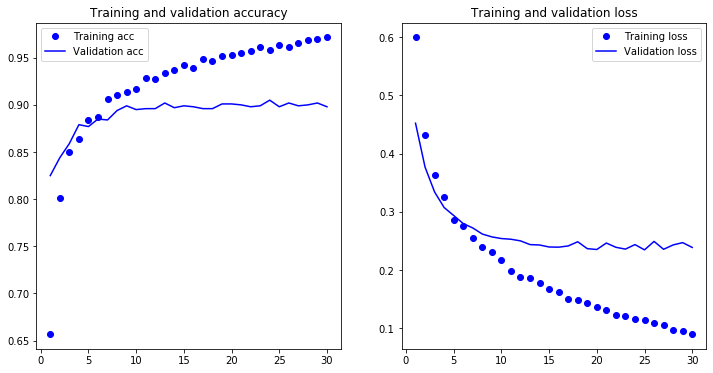

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

我们的验证精度达到了约`90%`，比上一节从头开始训练的小型模型效果要好得多。但从图中也可以看出，虽然`dropout`比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

##### 2. 使用数据增强的特征提取
下面我们来看一下特征提取的第二种方法，它的速度更慢，计算代价更高，但在训练期间可以使用数据增强。这种方法就是：扩展`conv_base`模型，然后在输入数据上端到端地运行模型。

> **注意**　
> 本方法计算代价很高，只在有GPU的情况下才能尝试运行。它在CPU上是绝对难以运行的。如果你无法在GPU上运行代码，那么就采用第一种方法。

模型的行为和层类似，所以你可以向`Sequential`模型中添加一个模型（比如`conv_base`），就像添加一个层一样。

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

现在模型的架构如下所示：

In [17]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


`VGG16`的卷积基有14714688个参数，非常多。在其上添加的分类器有200万个参数。

在编译和训练模型之前，一定要`冻结`卷积基。`冻结`（freeze）一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。因为其上添加的`Dense`层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏。

在`Keras`中，冻结网络的方法是将其`trainable`属性设为`False`。

In [19]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


如此设置之后，只有添加的两个`Dense`层的权重才会被训练。总共有4个权重张量，每层2个（主权重矩阵和偏置向量）。注意，为了让这些修改生效，你必须先编译模型。如果在编译之后修改了权重的`trainable`属性，那么应该重新编译模型，否则这些修改将被忽略。

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
# 注意，不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
# 编译训练
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

我们来再次绘制结果，验证精度约为`96%`。这比从头开始训练的小型卷积神经网络要好得多。

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 5.3.2 微调模型
另一种广泛使用的模型复用方法是`模型微调`（fine-tuning），与`特征提取`互为补充。对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练（见`图 5-19`）。之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。

<img src="images/05_19.png" style="width:200px;"/>

冻结`VGG16`的卷积基是为了能够在上面训练一个随机初始化的分类器。同理，只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。因此，微调网络的步骤如下。
1. 在已经训练好的基网络（base network）上添加自定义网络
2. 冻结基网络
3. 训练所添加的部分
4. 解冻基网络的一些层
5. 联合训练解冻的这些层和添加的部分

你在做特征提取时已经完成了前三个步骤。我们继续进行第四步：先解冻`conv_base`，然后冻结其中的部分层。

提醒一下，卷积基的架构如下所示。

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

我们将微调最后三个卷积层，也就是说，直到 block4_pool 的所有层都应该被冻结，而 block5_conv1、block5_conv2 和 block5_conv3 三层应该是可训练的。为什么不微调更多层？

为什么不微调整个卷积基？你当然可以这么做，但需要考虑以下几点。

卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在你的新问题上改变用途。微调更靠底部的层，得到的回报会更少。
训练的参数越多，过拟合的风险越大。卷积基有 1500 万个参数，所以在你的小型数据集上训练这么多参数是有风险的。
因此，在这种情况下，一个好策略是仅微调卷积基最后的两三层。我们从上一个例子结束的地方开始，继续实现此方法。